In this project we wanted to search the connection between the nutrition values on a food product to their price.
of course we know that there are more things that affects the price of a certain product, but in this project we'll look only at the nutrition values of the products

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as MSE

plt.style.use('seaborn')

In [2]:
df = pd.read_csv (r'C:\אריאל\שנה א\סמסטר א\מבוא למדעי הנתונים\עבודת הגמר\Data_Science_intro_project\Regression\data_converted_to_english.csv', index_col = False)

In [3]:
df.head()

,Product_Name,1_kg,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,...,chromium,Molybdenum,1_meter,100_meters,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
0,clementine,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,...,0,0,0,0,0,0,0,0,0,0
1,Gilded_apple,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,...,0,0,0,0,0,0,0,0,0,0
2,lemon,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,...,0,0,0,0,0,0,0,0,0,0
3,Orange_in_the_juice_network,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,...,0,0,0,0,0,0,0,0,0,0
4,Avocado,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9586 entries, 0 to 9585
Columns: 105 entries, Product_Name to Chlorophyll
dtypes: float64(27), int64(74), object(4)
memory usage: 7.7+ MB


In [5]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

In [6]:
prod = train_set.copy()

In [7]:
prod.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
prod= prod.set_index('Product_Name')

In [8]:
for col in prod.columns:  
    prod[col] = pd.to_numeric(prod[col], errors='coerce')
prod = prod.fillna(0)
sts_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index
prod = prod.loc[:, (prod != 0).any(axis=0)]

In [9]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7668 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 97 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1_kg                                 7668 non-null   float64
 1   Vitamin_B1                           7668 non-null   float64
 2   Vitamin_B6                           7668 non-null   float64
 3   Dietary_fiber                        7668 non-null   float64
 4   Folic_acid                           7668 non-null   float64
 5   energy                               7668 non-null   float64
 6   Proteins                             7668 non-null   float64
 7   Carbohydrates                        7668 non-null   float64
 8   Fats                                 7668 non-null   float64
 9   sodium                               7668 non-null   float64
 10  Vitamin_B3                           7668

### After a brief look at the cloumns we have, we pointed out a couple of things nedded to be done:
##### get rid of the unwanted units we have:
we want all the get rid of all the products that are not measured by 100_g or 1_kg (and delete the rows of these units).
afterwards, we need to unite the 100_g and 1_kg units (by deviding 1_kg by 10 we'll get the price for 100_g)
#### we'll check which columns left, and with them:
##### unite the columns:
- DHA_fatty_acid and DHA 
- Vitamin_A and Vitamin_A_is_worth_retinol 
- Dietary_fiber and Dietary_fiber.1 
- Potassium and K_Potassium (two different names to the same thing)
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E. (When referring generally to vitamin E, it is therefore related to the alpha-tocopherol form https://www.wikirefua.org.il/w/index.php/%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_-_Vitamin_-_E )
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3 (they are reffering to the same thing: https://en.wikipedia.org/wiki/Niacin)
- DHA and EPA with DHA_+_EPA (?)

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat
- DHA and EPA with DHA_+_EPA (?)

In [10]:
#first, we'll find the products without the wanted price units 
unwanted_units = prod[(prod['100_g']==0) & (prod['1_kg']==0)].index
print(unwanted_units)
#moreover, we'll check if there are any products with more than one wanted price units 
print(prod[(prod['100_g']!=0) & (prod['1_kg']!=0)].index)
#we'll notice that there are 807 products without the wanted price units and remove them
prod = prod.drop(unwanted_units) #dropes products with unwanted units
all_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero, such as columns of units that are not 100_g or 1_kg 
prod['1_kg'] = prod['1_kg']/10
prod['price_per_100g'] = prod['1_kg'] + prod['100_g']
prod = prod.drop(['100_g' ,'1_kg'], axis=1)

Index(['Milk_in_a_3%_fat_carton', '5%_Organic_White_Wine_Vinegar',
       'Grape_seed_oil', 'Alpero_Almond_Coconut_Drink', 'Ice_snacks',
       '22%_gluten-free_coconut_cream', 'Thai_sauce_Pad_Thai',
       'Solgar_Super_Gala_300', 'Sweet_chili_sauce', 'Organic_coconut_oil',
       ...
       'Wholemeal_bun_case', 'Soy_drink_for_LS_Alpro',
       'Coffee-flavored_soy_drink', 'Alpro_Chocolate_Soy_Drink', 'Magnox_520',
       'Coconut_cream_20-22%', 'Sweet_and_sour_sauce',
       'Organic_apple_cider_vinegar_5%', 'Donuts_cocoa_cream_+_candies',
       'Natural_apple_juice'],
      dtype='object', name='Product_Name', length=807)
Index([], dtype='object', name='Product_Name')


In [11]:
#in order to reduce background noise, we decided to drop the columns in which there are less than 10 products with this feature
prod = prod.reset_index()
arr = np.array([])
col_droped = np.array([])
for col in prod.columns:
    if prod[col].astype(bool).sum(axis=0)<10: #all the features that less than precent of the products have
        arr = np.append(arr, prod[col].to_numpy().nonzero())
        col_droped = np.append(col_droped, col)
print(arr)
arr = set(arr) #all number of rows without duplicates
for i in arr:
    prod = prod.drop(i)
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero
prod = prod.set_index(['Product_Name'])

[2323. 4379. 4727. 1551. 6439. 1283. 1551. 2079.  586. 3500. 4984. 5605.
 6026. 5605.  797. 4383. 5508. 1027. 2198. 2432. 2536. 2902. 3961. 6195.
  385. 5599. 3010. 3010.  137.  597. 2313. 6139. 1060. 2682. 2861. 2901.
 2982. 4086. 5897. 4052. 4485. 2413. 3039. 5787. 5880. 6360. 6609.  832.
 1043. 3085. 3823. 3920. 2108. 5582.  294. 2877. 4831. 6771.  222. 1800.
 2427. 2697. 3343. 3526. 4311. 4399.  583. 3931. 5675.  583. 3931. 5675.]


In [12]:
#all_dropped_collumns = all_dropped_collumns+sts_dropped_collumns
all_dropped_collumns

Index(['1_unit', '100_ml', '1_cm', 'DHA_+_EPA', 'Trans_fat', 'Acetic_acid',
       'Acidic_acid', 'Linoleic_acid', 'DHA', 'EPA', 'Chlorophyll'],
      dtype='object')

In [13]:
col_droped

array(['Monounsaturated_fat', 'Reduced_sodium', 'Lactose', 'caffeine',
       'Fat_without_trans', 'Pantothenic_acid',
       'Of_which_unsaturated_fat', '6_omega_fatty_acids',
       'From_sugars_to_organic_acids', 'wetness', 'ash', 'Lycopene',
       'Soluble_fiber', 'Oleic_fatty_acids', 'starch', 'AA_fatty_acid',
       'Vitamin_B3_Nicotinamide_Equilibrium', 'K_Potassium', 'humidity',
       'chromium', 'Molybdenum'], dtype='<U35')

noticed that DHA, EPA and DHA_+_EPA collumns fell in the filtering we did. Thus, these are the things we wanted to do and the ones we left with:
##### unite the columns:
~~- DHA_fatty_acid and DHA~~ 
- Vitamin_A and Vitamin_A_is_worth_retinol
- Dietary_fiber and Dietary_fiber.1
- Potassium and K_Potassium
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E.
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3

~~- DHA and EPA with DHA_+_EPA (?)~~

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat

~~- DHA and EPA with DHA_+_EPA (?)~~

Before we continued to work with the data, we wanted to scale the data in order to avoid any problems that might come with nutrition values that are measured by different units. We wanted to scale only the products and not the prices, so we splitted the prices from the nutrition values and then did the scaling. But before that we created another train and test set based on how many products has values in each column, beacuse logicly, the nutrition values we have more can help us predict the price to a wider range of products.

In [14]:
products_notscaled = prod.drop("price_per_100g", axis=1)
prices = prod["price_per_100g"].copy()

### creating another data set:

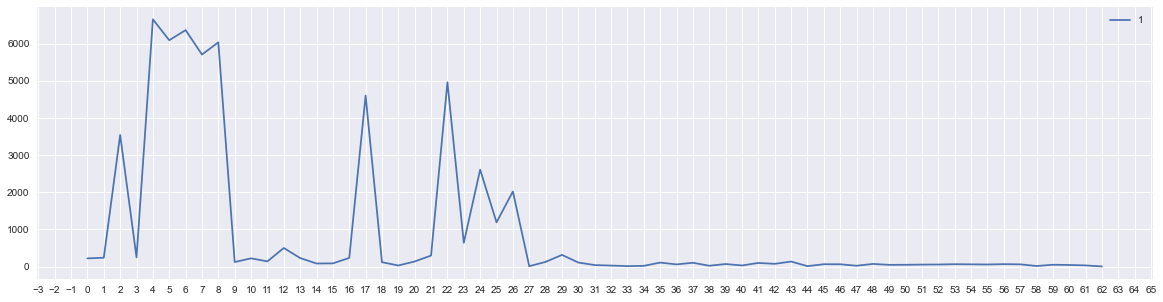

In [15]:
df_num = []
df_name = []
for col in products_notscaled.columns:
    df_num.append(int(products_notscaled[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator()) #Set a tick on each integer multiple of a base within the view interval.
plta.gcf().set_size_inches(20, 5)
plta.show() #in order to check which features can be given up
#it seems that starting from feature number 26, we can give up on those features
#it actually makes sense, because when we did the web scraping, it added to the keys, the names of the columns, 
#a name each time it was not already there. therefore, we would expect the common keys to be at the beginning of the columns

we can see from the graph that the mass of products we have with more than 1000 non-zero values is between columns 2 to 26. Based on that, we created a new data set of only these features and the price columns. (the reason we decided not to take specific columns is in order to prevent doing over fitting)

In the end, when we tried to run the models we decided what kind of filltering is the most worthy, and which features are better for predictions (what feature selection we should do)

In [16]:
products_notscaled2 = products_notscaled.iloc[:,2:26] 
prices2 = prices.copy()
products_notscaled2

,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,potassium,Vitamin_C,...,Magnesium,Carbohydrate_sugars,Vitamin_A,Dietary_fiber.1,zinc,Of_which_added_sugar,Of_which_saturated_fat,Trans_fatty_acids,Teaspoons_of_sugar,calcium
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.00,89.00,0.80,9.20,6.30,17.5,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,3.30,0.00,0.00,0.0
Pasta_Perfecto_Casserole,1.60,0.00,160.00,0.00,0.00,0.00,0.0,0.0,0,0.0,...,0,1.4,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
Whole_champignon_mushrooms,2.20,0.00,18.00,2.10,0.90,0.00,240.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
Light_bread_from_whole_spelled,2.45,0.00,38.88,3.07,8.46,0.39,86.9,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.12,0.00,0.00,0.0
Baby_bite_flavored_vegetables,0.00,0.00,8.00,0.00,2.00,0.00,6.0,0.0,0,0.0,...,0,0.3,0.0,0.0,0.0,0.0,0.10,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,0.00,335.00,6.30,76.00,0.00,0.0,0.0,0,0.0,...,0,45.0,0.0,0.0,0.0,0.0,0.00,0.00,11.25,0.0
Slim_Delis_Multi-Grain_Milk,1.60,7.22,59.00,0.80,7.40,2.60,36.4,0.7,0,0.0,...,0,4.4,34.5,0.0,0.0,0.0,1.40,0.00,8.75,0.0
Chocolate_with_popsicles,0.00,0.00,516.00,8.10,58.00,27.00,117.0,0.0,0,0.0,...,0,57.0,0.0,0.0,0.0,0.0,16.50,0.00,14.25,0.0


In [17]:
scaler = StandardScaler()

scaler.fit(products_notscaled2)
productsarr2 = scaler.transform(products_notscaled2) #scaler returns numpy array
products2 = pd.DataFrame(productsarr2, index=products_notscaled2.index, columns=products_notscaled2.columns)




scaler.fit(products_notscaled)
productsarr = scaler.transform(products_notscaled) #scaler returns numpy array
products = pd.DataFrame(productsarr, index=products_notscaled.index, columns=products_notscaled.columns)

In [18]:
products

,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,...,selenium,copper,Taurine,Choline,Inositol,Lutein,Alpha_linolenic_acid,chlorine,Carnitine,Chloride
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,-0.017238,-0.073257,-0.577147,-0.041641,-1.000219,-0.423746,-0.728020,-0.424512,-0.193390,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Pasta_Perfecto_Casserole,-0.017238,-0.073257,-0.205797,-0.041641,-0.598461,-0.470633,-1.037156,-0.850453,-0.199576,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Whole_champignon_mushrooms,-0.017238,-0.073257,-0.066541,-0.041641,-1.401978,-0.347555,-1.006914,-0.850453,-0.114730,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Light_bread_from_whole_spelled,-0.017238,-0.073257,-0.008517,-0.041641,-1.283827,-0.290705,-0.752885,-0.824085,-0.168855,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Baby_bite_flavored_vegetables,-0.017238,-0.073257,-0.577147,-0.041641,-1.458564,-0.470633,-0.969952,-0.850453,-0.197455,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,-0.017238,-0.073257,-0.577147,-0.041641,0.391789,-0.101400,1.516572,-0.850453,-0.199576,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Slim_Delis_Multi-Grain_Milk,-0.016921,0.461902,-0.205797,0.040841,-1.169976,-0.423746,-0.788503,-0.674668,-0.186708,1.142092,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186
Chocolate_with_popsicles,-0.017238,-0.073257,-0.577147,-0.041641,1.415991,0.004094,0.911742,0.975009,-0.158214,-0.086090,...,-0.061705,-0.064995,-0.061853,-0.059892,-0.069464,-0.04344,-0.058051,-0.058679,-0.048533,-0.017186


### uniting the desired columns:

In [19]:
def merge_two_columns(col1, col2, dataframe, index_col):
    if col1 in dataframe.columns and col2 in dataframe.columns:
        dataframe = dataframe.reset_index()
        row = 0
        for prod in dataframe[col1]:
            if (prod==0):
                if (dataframe.at[row , col2]!=0):
                    dataframe.at[row, col1] =  dataframe.at[row ,col2]  
            row = row+1
        dataframe = dataframe.drop([col2], axis = 1)
        dataframe = dataframe.set_index(index_col, drop=True)
        return dataframe
    else:
        return dataframe

In [20]:
products = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', products, 'Product_Name')
products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', products, 'Product_Name')
products = merge_two_columns('potassium', 'K_Potassium', products, 'Product_Name')
products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', products, 'Product_Name')
products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Niacin', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Nicotinamide', products, 'Product_Name')
products = merge_two_columns('sodium', 'chloride', products, 'Product_Name')

### checking the correlations:

###### checking the correlation between the Vitamin b's group:
we found on wikirefua that Folic acid = Vitamin B9, Niacin = Vitamin B3, Biotin = Vitamin B7 https://www.wikirefua.org.il/w/index.php?title=%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_B
It's written as well, that once, all the 8 types of Vitamin B(1, 2, 3, 5, 6, 7, 9, 12) were considered as the same vitamin - vitamin B.

In time, humanity found that they are different and each one has other functions. the reason why they all were considered the same Vitamoin is because they are often appears together in the same types of food. 

Hence, we'll try to find correlation between the different types of vitamin B, with the goal to unite them all under one column - Vitamin B group.

<AxesSubplot:>

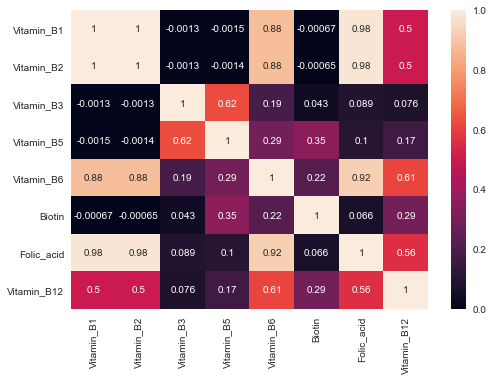

In [21]:
Bs = ['Vitamin_B1', 'Vitamin_B2', 'Vitamin_B3', 'Vitamin_B5', 'Vitamin_B6',  'Biotin', 'Folic_acid', 'Vitamin_B12']
vitamin_B = products.loc[:,Bs]
corrV = vitamin_B.corr()
sns.heatmap(corrV, annot=True)

From the graph we're concluding that the column we might want to take to represent the Vitamin B group is either Vitamin_B1, Vitamin_B3, Vitamin_B6 or Vitamin_B9 (Folic_acid). 

We chosed them by the number of correlations that are about>=0.8 (we didn't considered Vitamin_B2 because as we can see, the correlation between Vitamin_B1 and Vitamin_B2 is 1).

Now, we'll choose which one of the columns it will be by these criteria:
- the one with the most higher correlations
- the one with the least lower correlations
- the one with the biggest correlation with column we want to predict - price_per_100g

In [22]:
might_be_rep = ['Vitamin_B1', 'Vitamin_B6', 'Folic_acid']
for rep in might_be_rep:
    column_1 = prices
    column_2 = products[rep]
    correlation = column_1.corr(column_2)
    print(rep, ": number of correlations that are greater than 0.8: ", (corrV[rep].sort_values(ascending=False)>0.8).sum())
    print(rep, ": number of correlations that are below or equal 0.2: ", (corrV[rep].sort_values(ascending=False)<=0.2).sum())
    print("correlation between price_per_100g and ",rep,": ", correlation)

Vitamin_B1 : number of correlations that are greater than 0.8:  4
Vitamin_B1 : number of correlations that are below or equal 0.2:  3
correlation between price_per_100g and  Vitamin_B1 :  0.017879922052323343
Vitamin_B6 : number of correlations that are greater than 0.8:  4
Vitamin_B6 : number of correlations that are below or equal 0.2:  1
correlation between price_per_100g and  Vitamin_B6 :  0.027527916996205982
Folic_acid : number of correlations that are greater than 0.8:  4
Folic_acid : number of correlations that are below or equal 0.2:  3
correlation between price_per_100g and  Folic_acid :  0.02141036995635745


By the two first criteria we have putted first, it seems that the columns we should take as a representetive for the Vitamin B group is the column of Vitamin_B6 - it has the biggest number of correlations that are greater than 0.8 (which is 4), and it has the smallest number of correlations that are below or equal 0.2 (which is 1). It has, as well, the biggest correlation with price_per_100g.

we tried as well a different approach - instead of choosing one column to be the representetive of all the group, we tried to merge between the difeerent Vitamin Bs. we gave more significance to Vitamin_B6 and the one's that were designated to be the representetives by this order: first Vitamin_B6, then Vitamin_B9 (Folic_acid) (who has the best correlation with the price per 100g, and the smallest number of correlations that are below or equal 0.2 as well), After Vitamin_B1, the last of the might_be_rep. Then there was be Vitamin_B12 ,who has the same number of greater than 0.8 correlations as Vitamin_B5, but fewer correlations that are below or equal 0.2. And last but not least were Vitamin_B5, Biotin and Vitamin_B3 because we can see from the graph that Vitamin_B5 has the best higher correlations, Biotin the seconds, and Vitamin_B3 has the fewest.

we tried a different combinations of the code that appears in the next window, but it seemed that no matter what we did, the correlation between the column we tried to create to the price_per_100g stayed the same.

In the End we decided to stick with the Vitamin_B6 as the representor of this group, except for Vitamin_B5, Biotin and Vitamin_B3 who had lower correlations with the rest of the Vitamin Bs' group, so we wanted to look further into them.

In [23]:
products['Partof_vitaminB'] = products['Vitamin_B6']
products = products.drop(['Vitamin_B6','Vitamin_B1','Vitamin_B2','Vitamin_B12','Folic_acid'], axis=1)

In [24]:
corr_matrix = products.corr()
corr_matrix['Vitamin_B3'].sort_values(ascending=False).head(10)

Vitamin_B3              1.000000
Vitamin_B5              0.624983
iron                    0.275721
Vitamin_D.              0.224915
Partof_vitaminB         0.185874
calcium                 0.165787
Vitamin_A               0.160481
Alpha_linolenic_acid    0.159810
Vitamin_K.              0.154771
Inositol                0.152373
Name: Vitamin_B3, dtype: float64

In [25]:
corr_matrix = products.corr()
corr_matrix['Vitamin_B5'].sort_values(ascending=False).head(10)
#coudln't find the connection between copper and b5, bt found: the need for vitamin B5 is reduced in a copper-deficient(https://www.traceelements.com/Docs/The%20Nutritional%20Relationships%20of%20Copper.pdf)

Vitamin_B5              1.000000
Vitamin_B3              0.624983
Biotin                  0.351291
Partof_vitaminB         0.291994
iron                    0.236441
Ascorbic_acid           0.226245
Inositol                0.207285
Alpha_linolenic_acid    0.205767
Vitamin_K.              0.203478
copper                  0.195340
Name: Vitamin_B5, dtype: float64

In [26]:
corr_matrix = products.corr()
corr_matrix['Biotin'].sort_values(ascending=False).head(10)
#the only connection found between biotin and vitamin e is: both told to help with looks of skin and hair(https://www.everydayhealth.com/pictures/supplements-skin-hair/) 

Biotin                  1.000000
Vitamin_E.              0.361419
Vitamin_B5              0.351291
Vitamin_C               0.234850
Partof_vitaminB         0.223963
Choline                 0.209858
Inositol                0.205890
Alpha_linolenic_acid    0.204358
copper                  0.197393
Vitamin_K.              0.196938
Name: Biotin, dtype: float64

The highest correlation Vitamin_B5 and Vitamin_B3 has is with eac other. we couldn't find a reason to that connection between them, except of the fact that the method for determination of these vitamins in human biological materials is the same. 

Furthermore, because we did found a representitive of the majority of the Vitamin B group, we decided we wanted to look for a correlation within all the vitamin groups.

<AxesSubplot:>

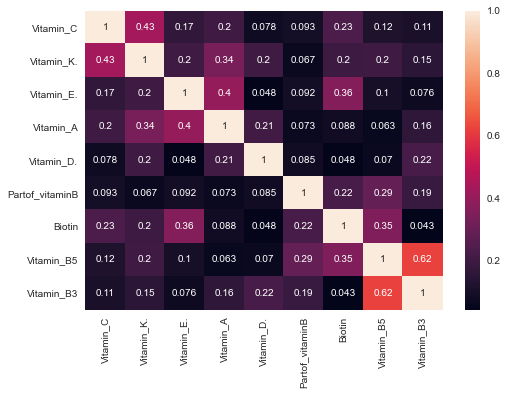

In [27]:
vitamins_lst=['Vitamin_C','Vitamin_K.','Vitamin_E.','Vitamin_A','Vitamin_D.' ,'Partof_vitaminB', 'Biotin', 'Vitamin_B5', 'Vitamin_B3']
vitaminS = products.loc[:,vitamins_lst]
corrvl = vitaminS.corr()
sns.heatmap(corrvl, annot=True)

There isn't a particulater high correlation. There is a weak connection (0.25<x<0.5) between them all, but we can attribute that to the fact that a lot of the times vitamin appears together in the same kinds of foods (such as fruits).

###### checking correlations between all the things that contains sugars (and Carbohydrate_sugars and Carbohydrate):

<AxesSubplot:>

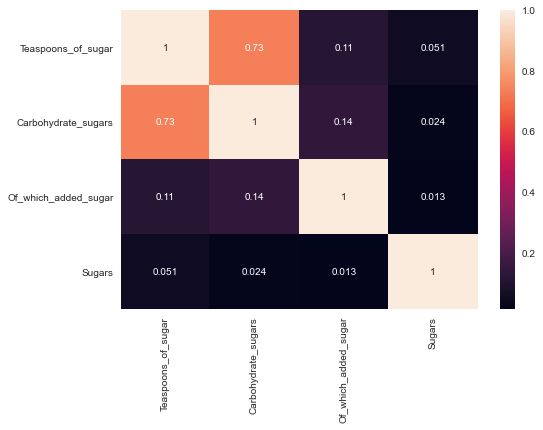

In [28]:
corr_matrix = products.corr()
Sm = ['Teaspoons_of_sugar', 'Carbohydrate_sugars', 'Of_which_added_sugar', 'Sugars'] #'From_sugars_to_organic_acids']
Sugars_matix = products.loc[:,Sm]
corrS = Sugars_matix.corr()
sns.heatmap(corrS,annot=True)

From the graph we can see that the only strong correlation there is between Teaspoons_of_sugar and Carbohydrate_sugars, which is about 0.8.

The correlation between "Teaspoons of sugar" and "Carbohydrate sugars" is high, beacuse as we found at https://www.camoni.co.il/411804/559434, a nutritionist named Marina Broshi explained that Teaspoons of sugar = Carbohydrate sugars/4. 

Now, We'll check the correlation between Teaspoons_of_sugar, Carbohydrate_sugars and price_per_100g (in order to decide on which of the two columns we should give up), But before we'll decide to drop the Carbohydrate sugars (if it'll come to that) column we''ll check as well the correlation between Carbohydrates and Carbohydrate_sugars, as we wanted before.

In [29]:
column_1 = products["Carbohydrate_sugars"]
column_2 = products["Carbohydrates"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrates and Carbohydrate_sugars ", correlation)

correlation between Carbohydrates and Carbohydrate_sugars  0.4546421372962511


The correlation between Carbohydrates and Carbohydrate_sugars is lower than the one between Carbohydrate_sugars and Teaspoons_of_sugar (where there is an exact formula to calculate the connection). 

Due to that, we decided to drop the Carbohydrate sugars column.

In [30]:
products = products.drop(['Carbohydrate_sugars'], axis=1)

###### checking correlations between energy and the rest of the nutrition values:

In [31]:
corr_matrix = products.corr()
corr_matrix["energy"].sort_values(ascending=False)
print(corr_matrix["energy"].sort_values(ascending=False))

energy                                 1.000000
Fats                                   0.755120
Carbohydrates                          0.437101
Teaspoons_of_sugar                     0.311993
Dietary_fiber                          0.228599
iron                                   0.142828
Proteins                               0.135402
Cholesterol                            0.095639
Of_which_saturated_fat                 0.085372
Trans_fatty_acids                      0.073985
Saturated_fatty_acids                  0.050320
phosphorus                             0.031121
potassium                              0.024993
Of_which_added_sugar                   0.021964
Magnesium                              0.018697
Saturated_fat                          0.018256
calcium                                0.016837
Polyunsaturated_fat                    0.015029
zinc                                   0.011798
Vitamin_E.                             0.008772
Biotin                                -0

The strong correlation between "energy" and "Fats" is high, beacuse as we found at wikipedia, https://he.wikipedia.org/wiki/%D7%A7%D7%9C%D7%95%D7%A8%D7%99%D7%94, energy, which is Calories can be calculated by: 1g of Fats=1g of energy*9 

In [32]:
column_1 = products["energy"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with energy ", correlation)
column_1 = products["Fats"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with Fats ", correlation)
products = products.drop(['energy'], axis=1) #the correlation with Fats is higher. thus, we'll drop the energy column

correlation with energy  0.03627238936618229
correlation with Fats  0.08294663316965706


###### checking correlations between the many kinds of fat: 
(we'll just point out that Linoleic_fatty_acid and Alpha_Linolenic_Acid are not the same fat acid. In they're compound, Linoleic_fatty_acid has 2 more hydrogen than Alpha_Linolenic_Acid)

Alpha_Linolenic_Acid(ALA)'s compound: C18H30O2 (https://en.wikipedia.org/wiki/Alpha-Linolenic_acid)

Linoleic_fatty_acid's compound: C18H32O2 (https://en.wikipedia.org/wiki/Linoleic_acid)

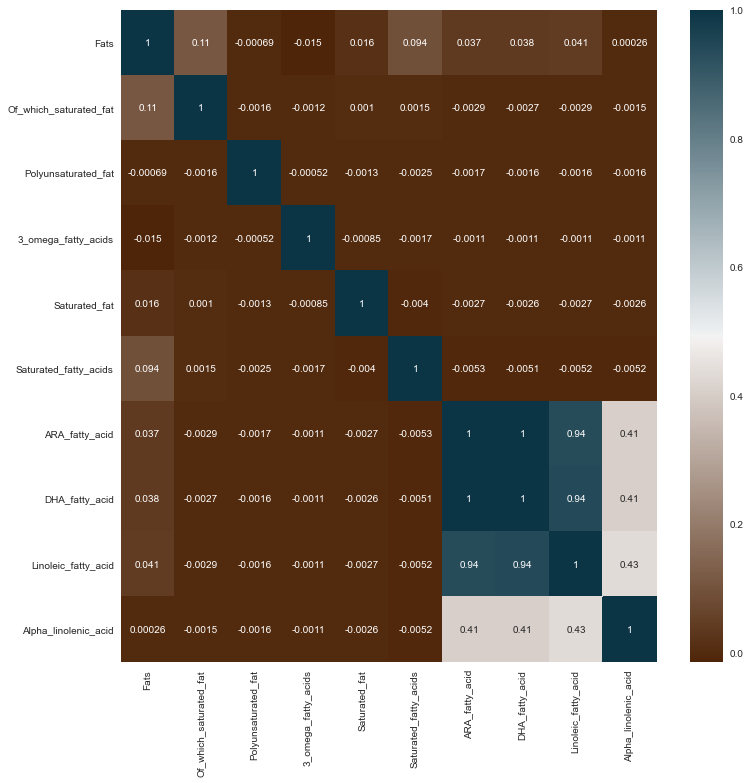

In [33]:
Ft = ['Fats','Of_which_saturated_fat','Polyunsaturated_fat','3_omega_fatty_acids','Saturated_fat','Saturated_fatty_acids'
             ,'ARA_fatty_acid', 'DHA_fatty_acid','Linoleic_fatty_acid','Alpha_linolenic_acid']
Fats_list = products.loc[:,Ft]
cmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(Fats_list.corr(),annot=True, cmap=cmap)
sns.set(font_scale=1)

we can see from graph that there is an area with a high correlation between three features - ARA_fatty_acid, DHA_fatty_acid and Linoleic_fatty_acid. The higher correlations are with ARA_fatty_acid so we decided to dig further in the origins of ARA_fatty_acid. 

we found out that Linoleic acid, ARA_fatty_acid are subsets of 6_omega_fatty_acids https://en.wikipedia.org/wiki/Omega-6_fatty_acid

We decided to unite these columns, but not before we checked does some of the fats we have are subsets of 3_omega_fatty_acids. we descovered that DHA_fatty_acid together with ALA (which is Alpha_Linolenic_Acid) are subsets of 3_omega_fatty_acids.https://en.wikipedia.org/wiki/Omega-3_fatty_acid

Also, we found that there is a connection between linoleic acids and oleic acids.

In [34]:
products['6_omega_fatty_acids'] = products['ARA_fatty_acid']
products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', products, 'Product_Name')

In [35]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6773 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 48 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Dietary_fiber                        6773 non-null   float64
 1   Proteins                             6773 non-null   float64
 2   Carbohydrates                        6773 non-null   float64
 3   Fats                                 6773 non-null   float64
 4   sodium                               6773 non-null   float64
 5   Vitamin_B3                           6773 non-null   float64
 6   potassium                            6773 non-null   float64
 7   Vitamin_C                            6773 non-null   float64
 8   iron                                 6773 non-null   float64
 9   Vitamin_K.                           6773 non-null   float64
 10  Vitamin_E.                           6773

In [36]:
products.corr()

,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,potassium,Vitamin_C,iron,Vitamin_K.,...,copper,Taurine,Choline,Inositol,Lutein,chlorine,Carnitine,Chloride,Partof_vitaminB,6_omega_fatty_acids
Dietary_fiber,1.000000,0.128960,0.126520,0.104364,-0.035576,0.047596,0.225424,-0.029013,0.286796,-0.037248,...,-0.035828,-0.034124,-0.033209,-0.038778,-0.023874,-0.032351,-0.026848,-0.006728,0.034609,-0.032878
Proteins,0.128960,1.000000,-0.025427,0.115350,-0.025063,-0.006414,0.026709,-0.026924,0.074998,-0.024947,...,-0.016549,0.003507,-0.015938,-0.017911,-0.015814,0.004782,0.001790,-0.006728,0.007132,0.003534
Carbohydrates,0.126520,-0.025427,1.000000,-0.000739,-0.098434,0.039508,0.134886,-0.042054,0.072118,-0.047749,...,-0.032498,0.011390,-0.032301,-0.034786,-0.034035,0.014685,-0.004203,-0.013229,0.001198,0.007807
Fats,0.104364,0.115350,-0.000739,1.000000,-0.053287,-0.031692,-0.013184,-0.043924,0.115250,-0.024965,...,-0.007058,0.039766,-0.011550,-0.008689,-0.026798,0.040845,0.028824,-0.010900,-0.026640,0.036792
sodium,-0.035576,-0.025063,-0.098434,-0.053287,1.000000,-0.010420,-0.004945,-0.015575,-0.027251,-0.015652,...,0.079317,-0.008965,-0.010731,-0.012360,-0.008262,-0.008346,-0.007203,-0.003308,-0.011460,-0.008614
Vitamin_B3,0.047596,-0.006414,0.039508,-0.031692,-0.010420,1.000000,0.032813,0.110353,0.275721,0.154771,...,0.151145,0.066145,0.151925,0.152373,-0.003740,0.066837,0.057449,-0.001480,0.185874,0.062261
potassium,0.225424,0.026709,0.134886,-0.013184,-0.004945,0.032813,1.000000,0.114000,0.274952,0.158379,...,0.142253,0.309217,0.106370,0.131654,0.032369,0.308130,0.225524,-0.002474,0.095596,0.297189
Vitamin_C,-0.029013,-0.026924,-0.042054,-0.043924,-0.015575,0.110353,0.114000,1.000000,0.049337,0.429153,...,0.314416,0.139910,0.331169,0.327473,0.081111,0.134857,0.118874,0.029926,0.092827,0.135031
iron,0.286796,0.074998,0.072118,0.115250,-0.027251,0.275721,0.274952,0.049337,1.000000,0.068302,...,0.064892,0.025111,0.068547,0.069619,0.014166,0.024146,0.018606,0.004859,0.166835,0.022648
Vitamin_K.,-0.037248,-0.024947,-0.047749,-0.024965,-0.015652,0.154771,0.158379,0.429153,0.068302,1.000000,...,0.791071,0.376988,0.836983,0.839987,0.233566,0.359829,0.303227,0.062141,0.066810,0.359235


<AxesSubplot:>

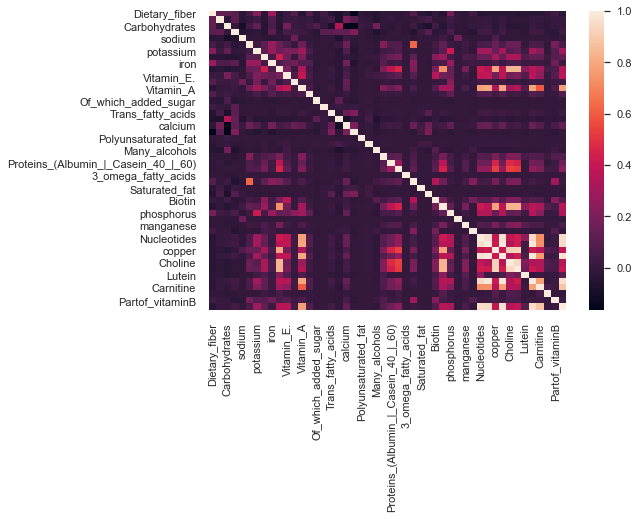

In [37]:
corr_matrix = products.corr()
sns.heatmap(corr_matrix) #in order to see if there's anything else worth checking

In [38]:
print(corr_matrix["Vitamin_A"].sort_values(ascending=False).head(15))
#didn't found the connection between the features, but:
#found a connection between taurine on toxicity of vitamin A in rats: https://www.sciencedirect.com/science/article/abs/pii/S0308814607005420
#found a comparison between chronic taurine and vitamin E plus selenium supplementations: https://pubmed.ncbi.nlm.nih.gov/12688428/
#found a rate studies of destruction of polyunsaturated fatty acids in vitro by chlorine-based disinfectants: https://pubmed.ncbi.nlm.nih.gov/1504266/
#we have consulted with a chimist but the only big connection was between the molecular structure of Vitamin_A and 6_omega_fatty_acids, and the fact that they are both dissolved in fat / both fatty

Vitamin_A              1.000000
selenium               0.799536
Taurine                0.797844
chlorine               0.792995
Nucleotides            0.780857
6_omega_fatty_acids    0.771216
Carnitine              0.599166
Vitamin_E.             0.401296
Inositol               0.352840
Vitamin_K.             0.337444
copper                 0.336136
iodine                 0.311630
phosphorus             0.293413
Choline                0.287615
potassium              0.286688
Name: Vitamin_A, dtype: float64


After we accomplished all of our goals from the beginning and in that preapered the data, we wanted to choose a performance measure. for a regression project, like ours there are a few performance measures. we decided to measure are project by RMSE, R^2.

RMSE means-

R^2 means-

what we'll do to a new data coming into the system (such as the test set):
(first set two, then set 1):
and then we checked the dummy regressor score

In [39]:
def data_ready_version_2(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('Product_Name')
    
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    
    
    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    
    dataw_notscaled2 = dataw.drop("price_per_100g", axis=1).iloc[:,2:26] 
    dataw_prices = dataw["price_per_100g"].copy()
    
    scaler.fit(products_notscaled2)
    dataw_scaledarr = scaler.fit_transform(dataw_notscaled2, products_notscaled2)
    dataw_scaled = pd.DataFrame(dataw_scaledarr, index=dataw_notscaled2.index, columns=dataw_notscaled2.columns)
    
    return dataw_scaled, dataw_prices

In [40]:
def data_ready_version_1(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('Product_Name')
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    dataw_notscaled = dataw.drop("price_per_100g", axis=1) 
    dataw_prices = dataw["price_per_100g"].copy()
    
    scaler.fit(products_notscaled)
    dataw_scaledarr = scaler.fit_transform(dataw_notscaled, products_notscaled)
    dataw_products = pd.DataFrame(dataw_scaledarr, index=dataw_notscaled.index, columns=dataw_notscaled.columns)
    
    dataw_products = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('potassium', 'K_Potassium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Niacin', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw_products, 'Product_Name')
    
    dataw_products['Partof_vitaminB'] = dataw_products['Vitamin_B6']
    dataw_products = dataw_products.drop(['Vitamin_B2', 'Vitamin_B6','Vitamin_B3','Folic_acid','Vitamin_B1','Vitamin_B12'
                              ,'Carbohydrate_sugars','energy'], axis=1)
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'AA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw_products, 'Product_Name')
    
    return dataw_products, dataw_prices

In [41]:
def RMSE(real, prediction):
    return np.sqrt(MSE(real, prediction))

In [42]:
#test_set_prod2, test_set_prices2 = data_ready_version_2(test_set)

In [43]:
#test_set_prod1, test_set_prices1 = data_ready_version_1(test_set)

In [44]:
'''dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products, prices)
predictdum2 = dummy_regr.predict(test_set_prod2)
mser = RMSE(test_set_prices2, predictdum2)
print( "mean squered error of " + str(mser)[:4])'''

'dummy_regr = DummyRegressor(strategy="mean")\ndummy_regr.fit(products, prices)\npredictdum2 = dummy_regr.predict(test_set_prod2)\nmser = RMSE(test_set_prices2, predictdum2)\nprint( "mean squered error of " + str(mser)[:4])'

In [45]:
'''dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products, prices)
predictdum1 = dummy_regr.predict(test_set_prod1)
mser = RMSE(test_set_prices1, predictdum1)
print( "mean squered error of " + str(mser)[:4])'''

'dummy_regr = DummyRegressor(strategy="mean")\ndummy_regr.fit(products, prices)\npredictdum1 = dummy_regr.predict(test_set_prod1)\nmser = RMSE(test_set_prices1, predictdum1)\nprint( "mean squered error of " + str(mser)[:4])'

(it make sense that for both of the preperations the score of the dummy regressor is the same beacuse we did scaling so there is an even distribution, so the score of mean is the same). 

# end of data cleaning

# linear regression

In [46]:
def maxN(elements, n):
    return sorted(elements, reverse=True)[:n]

In [47]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
lin_reg = LinearRegression()

#products = products.drop(['wetness','ash'],axis=1)
print(products.shape, prices.shape)
predict1 = cross_val_predict(lin_reg, products, prices, cv=kf)
a=0
for i in predict1:
    print(i, a)
    a=a+1
print(maxN(predict1, 10))
rmse_linreg1 = RMSE(prices, predict1)
print(rmse_linreg1)

lin_reg = LinearRegression()
predict2 = cross_val_predict(lin_reg, products2, prices2, cv=kf)
rmse_linreg2 = RMSE(prices2, predict2)
print(rmse_linreg2)

(6773, 48) (6773,)
7.57793824912925 0
6.8172825516926 1
6.816017083567314 2
6.550075551723535 3
6.894739747751774 4
7.820846833623418 5
5.813605507852338 6
4.198761540971182 7
6.346058440793264 8
7.454907134264252 9
8.459636728680534 10
7.29267416698642 11
6.4801168802384765 12
6.224912602300245 13
11.31828814976136 14
4.41491596175679 15
7.413795792667653 16
6.9079370326316445 17
4.417671394579618 18
9.651304979749908 19
8.174641282021968 20
6.684889436452577 21
7.316747471486159 22
7.025837150776747 23
7.160281939424379 24
6.647762902584247 25
15.212054191593818 26
6.926759213050208 27
11.444386539419119 28
6.790556648415976 29
6.090177373035489 30
9.012871779280403 31
12.774711337776724 32
7.034807333221879 33
8.671963873778648 34
6.6140606325310065 35
9.298788630151474 36
6.895700389940588 37
6.711539547424411 38
6.596512857941668 39
4.738681253519609 40
7.304591552217387 41
8.925124110671913 42
6.317040074273833 43
5.956033752218338 44
5.550779231378159 45
6.9341152741620595 46
6.

7.007979925667648 1061
5.481020385786169 1062
7.598856344263185 1063
6.681166254671164 1064
7.175956565670552 1065
9.243867037653438 1066
4.478162694595891 1067
6.653458791647886 1068
6.565088236885964 1069
8.002417876635334 1070
5.719664909468208 1071
6.585764781405534 1072
5.616471021863617 1073
9.195754721075893 1074
9.092159649475938 1075
7.389034631616422 1076
6.7998120381996765 1077
5.808163257533302 1078
6.883537935000135 1079
5.692732030113772 1080
6.828391632068494 1081
7.509341939707326 1082
6.890933848478519 1083
6.847727783944517 1084
8.799417529454834 1085
8.18812507852894 1086
6.949509773920343 1087
6.0994520010704 1088
7.523653443313295 1089
6.324845704336871 1090
10.277677473669739 1091
6.7653551861008125 1092
7.423854738860312 1093
6.037427720844913 1094
7.444214120557964 1095
7.563683888634878 1096
8.833169955701857 1097
6.943349200874391 1098
10.107137181771616 1099
6.711136140103867 1100
11.483768099120551 1101
8.51072725076333 1102
5.858575258640431 1103
6.77050671

9.405431649777832 1788
7.446883777839113 1789
7.181422723611909 1790
9.74840408946792 1791
15.011388211318572 1792
8.733766569662 1793
7.354482286940199 1794
7.574400148896034 1795
4.335840668905307 1796
6.510393072903275 1797
7.793783354187625 1798
6.963137450545098 1799
9.587165921600247 1800
7.618068420641724 1801
7.261671353159607 1802
6.949963848841734 1803
6.240400386654116 1804
6.479748911329683 1805
9.20589679404513 1806
10.22646703537038 1807
7.446114510000546 1808
7.448472676741099 1809
7.075177262232848 1810
6.793303355320331 1811
7.216923656369051 1812
6.749502730678181 1813
8.610679416053989 1814
6.870791613706828 1815
7.248669305093001 1816
9.480962440591224 1817
7.706568021356792 1818
7.3471065723124545 1819
6.726335374474145 1820
6.857751726634562 1821
7.814453499089741 1822
5.781298500625304 1823
9.310579076869836 1824
6.727640871942345 1825
7.445735457127244 1826
6.713697225046922 1827
8.44356019501224 1828
7.819060681361019 1829
4.9817949843334794 1830
6.850933014002

5.404339259900471 2671
6.048560549122734 2672
8.571261834764876 2673
5.871842161021682 2674
8.691622107606419 2675
9.052377118422303 2676
7.729078388625228 2677
8.99030215566198 2678
7.050933395156764 2679
6.823458475199935 2680
4.545261253256608 2681
7.794854754871231 2682
6.653241992647455 2683
10.383391910500123 2684
4.686371492172411 2685
7.083042267461014 2686
7.730646345843126 2687
5.171905201358632 2688
8.399958932850344 2689
6.342214863623404 2690
10.557555201252388 2691
6.6308473263751955 2692
4.950873448279296 2693
6.971149070758738 2694
6.243339824765535 2695
7.975765823783917 2696
6.717435104341382 2697
5.633017883936404 2698
8.919462616432492 2699
7.338213289655746 2700
7.534195164924526 2701
7.499535285635801 2702
17.91846143735024 2703
9.420969041225106 2704
7.001794294248883 2705
6.8147763268927255 2706
15.020355450662102 2707
8.44645864714866 2708
7.0318453329015345 2709
7.805373161951131 2710
6.076910070099682 2711
8.524230481360588 2712
5.093659262049789 2713
6.52227

7.044983461029025 3591
7.262645039473443 3592
5.032321069969788 3593
7.218106150723599 3594
7.630366889778978 3595
5.992305697527913 3596
5.986547090091988 3597
5.2166527771597995 3598
5.044801623892395 3599
7.638056111082578 3600
7.841093339367573 3601
4.3836632997001415 3602
6.63292485751079 3603
8.520025777964909 3604
3.9428681498425973 3605
6.849548315700766 3606
6.9206682839022635 3607
8.844725556528955 3608
6.961883644978681 3609
7.215485528601839 3610
7.334547674598513 3611
12.454625969805214 3612
6.172648347014215 3613
6.879838719507255 3614
6.899665484380125 3615
6.641718192832126 3616
6.158284507168615 3617
6.996286149962059 3618
7.198298608658308 3619
6.84761352228311 3620
5.313215944213495 3621
9.458569534271913 3622
7.075410230609892 3623
7.687556220522888 3624
5.695841697899455 3625
7.418017661042774 3626
6.367138804311362 3627
15.388269185462427 3628
6.284339620077445 3629
7.612326048785006 3630
6.737913618927885 3631
8.944264487743933 3632
6.259189425151234 3633
6.43562

6.8044924119922054 4496
7.317060796634209 4497
5.691269701376463 4498
6.987479401892502 4499
6.710312499848015 4500
9.175216861751549 4501
6.8576078012582045 4502
5.12727689025187 4503
6.474386544132439 4504
8.14132367389618 4505
7.220569235032857 4506
6.843836884965765 4507
7.298417878295262 4508
4.5116767274526755 4509
6.777572106827748 4510
7.764833215830425 4511
7.682153784972379 4512
4.84199307865155 4513
7.134973136014987 4514
5.74610113568445 4515
6.962406234159006 4516
7.8992263296044385 4517
6.888710894483631 4518
6.229830762138107 4519
10.666961429477942 4520
6.816474471123673 4521
7.656400190077644 4522
6.636581765992473 4523
6.930184748806505 4524
6.4854808441378236 4525
1.0705447233878438 4526
7.941628017804923 4527
6.583878759894262 4528
10.17139145824885 4529
8.490038734245214 4530
7.671201456543 4531
6.9830689276009 4532
9.584681181088879 4533
7.595002089606242 4534
6.837356623832433 4535
6.336814918214811 4536
6.916972633081956 4537
8.324382281572216 4538
7.12116542438

8.221335329990046 5381
9.623255689264138 5382
6.747415585886368 5383
6.821115458832328 5384
5.855035341459192 5385
6.663109614584288 5386
8.177921570450856 5387
9.129682318268813 5388
7.691230136393353 5389
7.521118643626838 5390
15.019705179037665 5391
8.447518816146736 5392
8.970232550244862 5393
8.238331620794447 5394
4.527345496085275 5395
6.355762428357357 5396
6.165928429075509 5397
6.692644958882713 5398
6.698989832723654 5399
5.38880987413388 5400
7.024458300883975 5401
7.915041758956309 5402
6.546870143122811 5403
7.655839441310296 5404
6.767119112253505 5405
6.756576748265573 5406
7.635324613012047 5407
6.156744557471951 5408
4.771861998599405 5409
10.616032115954866 5410
6.877174984295574 5411
7.053859404758175 5412
7.686922080625512 5413
6.946159225641736 5414
7.1118823812510295 5415
0.8975951929808259 5416
7.010998435057423 5417
7.7520457818215975 5418
8.904937637321433 5419
5.225308088456159 5420
6.945270445896839 5421
6.8100904469181565 5422
8.614484046201847 5423
3.8018

6.748349101344837 6289
8.204147728997201 6290
4.928869786475081 6291
6.01799707834347 6292
7.436894755692974 6293
4.780396927529443 6294
10.077353309419163 6295
6.655788635695917 6296
10.467448453776182 6297
6.673635487799934 6298
5.996315334166582 6299
6.867302912787053 6300
4.524788151365879 6301
5.0140293847963235 6302
11.301999936306165 6303
6.986639840661977 6304
6.160955352286463 6305
6.1940753875677315 6306
7.069567331794414 6307
6.775785881646268 6308
7.259273098317212 6309
6.284302718000539 6310
7.088858507502368 6311
5.841843386562542 6312
7.704849197123945 6313
6.301427498650829 6314
6.809296787455941 6315
6.5159104968178125 6316
7.322087384318539 6317
6.892629092252476 6318
8.08184461705871 6319
8.37257061510769 6320
5.230912284491186 6321
5.4771911897120695 6322
9.22577940724706 6323
7.1283884161342135 6324
6.931051427839598 6325
7.223431772079271 6326
7.037688201822593 6327
6.250147151530847 6328
6.523128552508985 6329
6.654388337272514 6330
10.813609486083784 6331
7.2188

10.042000966981579


Feature: 0, Score: 0.07805
Feature: 1, Score: 0.03641
Feature: 2, Score: -0.83780
Feature: 3, Score: 0.78535
Feature: 4, Score: 0.20982
Feature: 5, Score: -0.33836
Feature: 6, Score: -0.12589
Feature: 7, Score: -0.21950
Feature: 8, Score: -0.14998
Feature: 9, Score: -0.23767
Feature: 10, Score: 0.39707
Feature: 11, Score: 0.03101
Feature: 12, Score: -0.10665
Feature: 13, Score: -0.01555
Feature: 14, Score: -0.21951
Feature: 15, Score: -0.01534
Feature: 16, Score: -0.04126
Feature: 17, Score: 0.69545
Feature: 18, Score: 0.04547
Feature: 19, Score: 0.12001
Feature: 20, Score: -0.04974
Feature: 21, Score: -0.17464
Feature: 22, Score: 1.34941
Feature: 23, Score: 0.04931
Feature: 24, Score: -0.09805
Feature: 25, Score: 0.08412
Feature: 26, Score: 0.02966
Feature: 27, Score: 0.53889
Feature: 28, Score: 0.08541
Feature: 29, Score: -0.01060
Feature: 30, Score: -0.38832
Feature: 31, Score: 0.18768
Feature: 32, Score: -0.10424
Feature: 33, Score: -0.11563
Feature: 34, Score: -0.06608
Feature: 35

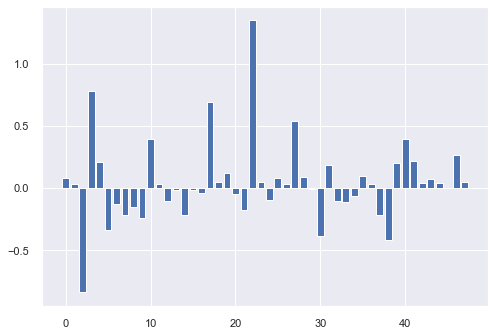

Feature: 2, Score: -0.83780
Feature: 3, Score: 0.78535
Feature: 5, Score: -0.33836
Feature: 10, Score: 0.39707
Feature: 17, Score: 0.69545
Feature: 22, Score: 1.34941
Feature: 27, Score: 0.53889
Feature: 30, Score: -0.38832
Feature: 38, Score: -0.41933
Feature: 40, Score: 0.39895


In [48]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products, prices)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm =[]
for i,v in enumerate(importance):
    if abs(v)>0.3:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [49]:
lin_reg = LinearRegression()
productsv = products.iloc[:,listm]
predict = cross_val_predict(lin_reg, productsv, prices, cv=kf)
rmse_linreg = RMSE(prices, predict)
print(rmse_linreg)

9.955920400858872


Feature: 0, Score: 0.06462
Feature: 1, Score: 2.23627
Feature: 2, Score: -0.63334
Feature: 3, Score: 0.02728
Feature: 4, Score: -0.31752
Feature: 5, Score: 1.24613
Feature: 6, Score: 0.13090
Feature: 7, Score: -0.16932
Feature: 8, Score: -0.22661
Feature: 9, Score: -0.27236
Feature: 10, Score: -0.22889
Feature: 11, Score: -1.98498
Feature: 12, Score: 0.13400
Feature: 13, Score: 0.19808
Feature: 14, Score: 0.00892
Feature: 15, Score: 0.39683
Feature: 16, Score: -0.04562
Feature: 17, Score: 0.24178
Feature: 18, Score: -0.01832
Feature: 19, Score: -0.25979
Feature: 20, Score: -0.01254
Feature: 21, Score: -0.02016
Feature: 22, Score: 0.26065
Feature: 23, Score: 0.12081


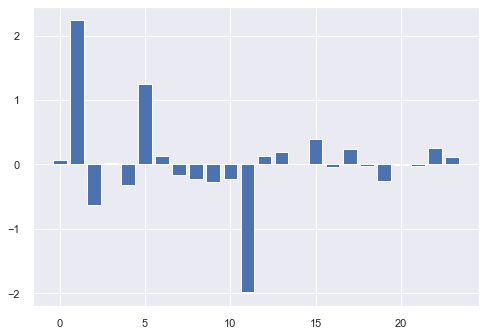

Feature: 0, Score: 0.06462
Feature: 1, Score: 2.23627
Feature: 2, Score: -0.63334
Feature: 3, Score: 0.02728
Feature: 4, Score: -0.31752
Feature: 5, Score: 1.24613
Feature: 6, Score: 0.13090
Feature: 7, Score: -0.16932
Feature: 8, Score: -0.22661
Feature: 9, Score: -0.27236
Feature: 10, Score: -0.22889
Feature: 11, Score: -1.98498
Feature: 12, Score: 0.13400
Feature: 13, Score: 0.19808
Feature: 14, Score: 0.00892
Feature: 15, Score: 0.39683
Feature: 16, Score: -0.04562
Feature: 17, Score: 0.24178
Feature: 18, Score: -0.01832
Feature: 19, Score: -0.25979
Feature: 20, Score: -0.01254
Feature: 21, Score: -0.02016
Feature: 22, Score: 0.26065
Feature: 23, Score: 0.12081


In [50]:
from matplotlib import pyplot
model = LinearRegression()
model.fit(products2, prices2)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

listm =[]
for i,v in enumerate(importance):
    if abs(v)>0.0000001:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listm.append(i)

In [51]:
lin_reg = LinearRegression()
productsv2 = products.iloc[:,listm]
predict2 = cross_val_predict(lin_reg, productsv2, prices2, cv=kf)
rmse_linreg2 = RMSE(prices, predict2)
print(rmse_linreg2)

9.974373939646343


we can see that there are 2 outliers
tried to remove them but then there were 2 other outliers
couldn't find a reasonable explenation
it seems that linear regression is not a good model for this problem

# desicion tree regression

In [52]:
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products, prices, cv=kf)
rmse_score1 = RMSE(prices, predicttree1)
print(rmse_score1)

predicttree2 = cross_val_predict(tree_reg, products2, prices2, cv=kf)
rmse_score2 = RMSE(prices2, predicttree2)
print(rmse_score2)

10.229055184628695
10.014390131262267


Feature: 0, Score: 0.02204
Feature: 1, Score: 0.29272
Feature: 2, Score: 0.06161
Feature: 3, Score: 0.01977
Feature: 4, Score: 0.48056
Feature: 5, Score: 0.00031
Feature: 6, Score: 0.00057
Feature: 7, Score: 0.00008
Feature: 8, Score: 0.00320
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00082
Feature: 11, Score: 0.00090
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00006
Feature: 14, Score: 0.00102
Feature: 15, Score: 0.04631
Feature: 16, Score: 0.00143
Feature: 17, Score: 0.01308
Feature: 18, Score: 0.00482
Feature: 19, Score: 0.00991
Feature: 20, Score: 0.00031
Feature: 21, Score: 0.00017
Feature: 22, Score: 0.02776
Feature: 23, Score: 0.00008
Feature: 24, Score: 0.00001
Feature: 25, Score: 0.00022
Feature: 26, Score: 0.00001
Feature: 27, Score: 0.00008
Feature: 28, Score: 0.00006
Feature: 29, Score: 0.00004
Feature: 30, Score: 0.00012
Feature: 31, Score: 0.00050
Feature: 32, Score: 0.00005
Feature: 33, Score: 0.00009
Feature: 34, Score: 0.00001
Feature: 35, Score: 0.00274
Fe

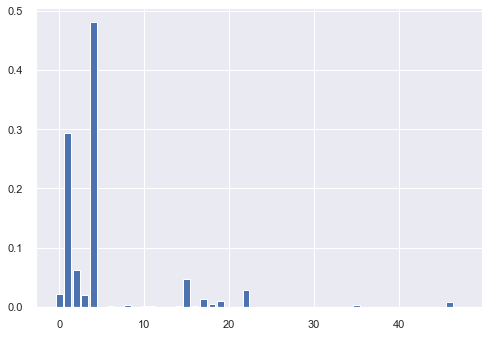

Feature: 0, Score: 0.02204
Feature: 1, Score: 0.29272
Feature: 2, Score: 0.06161
Feature: 3, Score: 0.01977
Feature: 4, Score: 0.48056
Feature: 8, Score: 0.00320
Feature: 14, Score: 0.00102
Feature: 15, Score: 0.04631
Feature: 16, Score: 0.00143
Feature: 17, Score: 0.01308
Feature: 18, Score: 0.00482
Feature: 19, Score: 0.00991
Feature: 22, Score: 0.02776
Feature: 35, Score: 0.00274
Feature: 46, Score: 0.00832


In [53]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products, prices)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi = []
for i,v in enumerate(importance):
    if v>0.001:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi.append(i)

In [54]:
products_3 = products.iloc[:,listi]
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products_3, prices, cv=kf)
rmse_score1 = RMSE(prices, predicttree1)
print(rmse_score1)

10.2143642810872


Feature: 0, Score: 0.01840
Feature: 1, Score: 0.00237
Feature: 2, Score: 0.07244
Feature: 3, Score: 0.29764
Feature: 4, Score: 0.03703
Feature: 5, Score: 0.02271
Feature: 6, Score: 0.41782
Feature: 7, Score: 0.00018
Feature: 8, Score: 0.00015
Feature: 9, Score: 0.00008
Feature: 10, Score: 0.00276
Feature: 11, Score: 0.00795
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00084
Feature: 14, Score: 0.00044
Feature: 15, Score: 0.02333
Feature: 16, Score: 0.00131
Feature: 17, Score: 0.00004
Feature: 18, Score: 0.00002
Feature: 19, Score: 0.00173
Feature: 20, Score: 0.04574
Feature: 21, Score: 0.00184
Feature: 22, Score: 0.04155
Feature: 23, Score: 0.00364


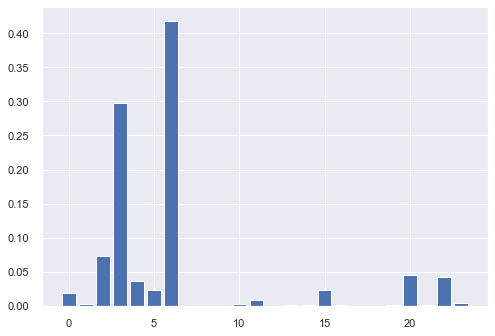

Feature: 0, Score: 0.01840
Feature: 1, Score: 0.00237
Feature: 2, Score: 0.07244
Feature: 3, Score: 0.29764
Feature: 4, Score: 0.03703
Feature: 5, Score: 0.02271
Feature: 6, Score: 0.41782
Feature: 10, Score: 0.00276
Feature: 11, Score: 0.00795
Feature: 15, Score: 0.02333
Feature: 16, Score: 0.00131
Feature: 19, Score: 0.00173
Feature: 20, Score: 0.04574
Feature: 21, Score: 0.00184
Feature: 22, Score: 0.04155
Feature: 23, Score: 0.00364


In [55]:
from matplotlib import pyplot
model = DecisionTreeRegressor()
model.fit(products2, prices2)
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
listi2 = []
for i,v in enumerate(importance):
    if v>0.0012:
        print('Feature: %0d, Score: %.5f' % (i,v))
        listi2.append(i)

In [56]:
products2_3 = products.iloc[:,listi2]
tree_reg = DecisionTreeRegressor()

predicttree2 = cross_val_predict(tree_reg, products2_3, prices2, cv=kf)
rmse_score2 = RMSE(prices2, predicttree2)
print(rmse_score2)

8.787462949600583


# random forest regressor

In [57]:
random_for = RandomForestRegressor()

prodicrfor1 = cross_val_predict(random_for, products, prices, cv=kf)
rmsefor = RMSE(prices, prodicrfor1)
print(rmsefor)

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2, prices2, cv=kf)
rmsefor2 = RMSE(prices, prodicrfor2)
print(rmsefor2)

7.1982176811812195
7.386702760458796


Feature: 0, Score: 0.03452
Feature: 1, Score: 0.00507
Feature: 2, Score: 0.09748
Feature: 3, Score: 0.08302
Feature: 4, Score: 0.04931
Feature: 5, Score: 0.03597
Feature: 6, Score: 0.43714
Feature: 7, Score: 0.00008
Feature: 8, Score: 0.00039
Feature: 9, Score: 0.00052
Feature: 10, Score: 0.00349
Feature: 11, Score: 0.00559
Feature: 12, Score: 0.00017
Feature: 13, Score: 0.00071
Feature: 14, Score: 0.00101
Feature: 15, Score: 0.11094
Feature: 16, Score: 0.00070
Feature: 17, Score: 0.00046
Feature: 18, Score: 0.00027
Feature: 19, Score: 0.00138
Feature: 20, Score: 0.07945
Feature: 21, Score: 0.00204
Feature: 22, Score: 0.04596
Feature: 23, Score: 0.00434


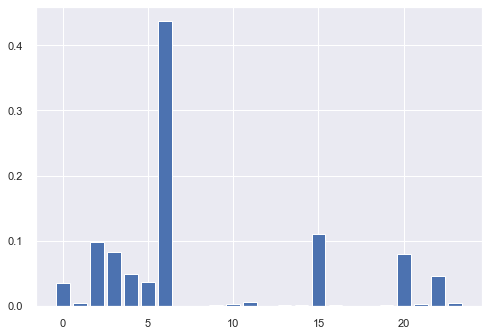

Feature: 2, Score: 0.09748
Feature: 6, Score: 0.43714
Feature: 15, Score: 0.11094


In [58]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products2, prices2)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
for i,v in enumerate(importance):
    if v>0.09:
        print('Feature: %0d, Score: %.5f' % (i,v))

In [59]:
v_2_2 = [0,2,3,4,5,6,10,11,14,15,19,20,21,22,23]
products2_2 = products.iloc[:,v_2_2]

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2_2, prices2, cv=kf)
rmsefor2 = RMSE(prices2, prodicrfor2)
print(rmsefor2)

7.177936758404845


Feature: 0, Score: 0.04704
Feature: 1, Score: 0.09885
Feature: 2, Score: 0.09173
Feature: 3, Score: 0.05577
Feature: 4, Score: 0.50380
Feature: 5, Score: 0.00009
Feature: 6, Score: 0.00042
Feature: 7, Score: 0.00017
Feature: 8, Score: 0.00341
Feature: 9, Score: 0.00003
Feature: 10, Score: 0.00087
Feature: 11, Score: 0.00129
Feature: 12, Score: 0.00071
Feature: 13, Score: 0.00014
Feature: 14, Score: 0.00094
Feature: 15, Score: 0.08458
Feature: 16, Score: 0.00589
Feature: 17, Score: 0.04692
Feature: 18, Score: 0.00715
Feature: 19, Score: 0.01112
Feature: 20, Score: 0.00023
Feature: 21, Score: 0.00017
Feature: 22, Score: 0.02802
Feature: 23, Score: 0.00009
Feature: 24, Score: 0.00001
Feature: 25, Score: 0.00017
Feature: 26, Score: 0.00017
Feature: 27, Score: 0.00017
Feature: 28, Score: 0.00009
Feature: 29, Score: 0.00017
Feature: 30, Score: 0.00046
Feature: 31, Score: 0.00017
Feature: 32, Score: 0.00019
Feature: 33, Score: 0.00010
Feature: 34, Score: 0.00002
Feature: 35, Score: 0.00400
Fe

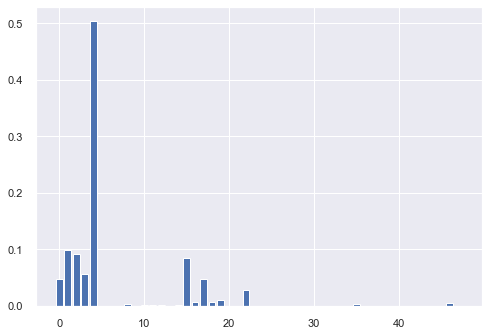

Feature: 0, Score: 0.04704
Feature: 1, Score: 0.09885
Feature: 2, Score: 0.09173
Feature: 3, Score: 0.05577
Feature: 4, Score: 0.50380
Feature: 15, Score: 0.08458
Feature: 17, Score: 0.04692
Feature: 19, Score: 0.01112
Feature: 22, Score: 0.02802


In [60]:
from matplotlib import pyplot
random_for = RandomForestRegressor()
random_for.fit(products, prices)
importance = random_for.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
for i,v in enumerate(importance):
    if v>0.01:
        print('Feature: %0d, Score: %.5f' % (i,v))

In [61]:
v_2_1=[0,1,2,3,4,14,16,18,21]
products_2 = products.iloc[:,v_2_1]

random_for = RandomForestRegressor()
prodicrfor = cross_val_predict(random_for, products_2, prices, cv=kf)
rmsefor = RMSE(prices, prodicrfor)
print(rmsefor)

7.970772024950899


In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [10, 20, 30, 40, 50]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [10, 20, 30, 40, 50]},
 ]
grid_search = GridSearchCV(random_for, param_grid, cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(products, prices)
grid_search.best_params_

C:\Users\shira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shira\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

C:\Users\shira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shira\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\shira\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

{'bootstrap': False, 'max_features': 20, 'n_estimators': 10}